In [1]:
import scanpy as sc
import numpy as np
import phate 
from scipy.spatial.distance import pdist, squareform
from data import train_valid_loader_from_pc
from model import AEDist
import torch
from transformations import LogTransform, NonTransform, StandardScaler, \
    MinMaxScaler, PowerTransformer, KernelTransform

from geodesic import ODEFunc, GeodesicODE

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
import pandas as pd

sc.set_figure_params(figsize=(3, 3))
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

## Plotting function

## Testing

In [2]:
# Read anndata and get gene expression 
adata = sc.read_h5ad("/home/icb/alessandro.palma/environment/scCFM/project_dir/data/pancreas/processed/pancreas.h5ad")
X_expression = np.array(adata.X.copy().todense())

# Initialize and compute PHATE embedding 
phate_op = phate.PHATE()
phate_coords = phate_op.fit_transform(X_expression)

# Mutual distance as a squared matrix 
phate_D = squareform(pdist(phate_coords))
dist_std = np.std(phate_D.flatten())

trainloader, valloader, mean, std = train_valid_loader_from_pc(
            X_expression, # <---- Pointcloud
            phate_D, # <---- Distance matrix to match
            batch_size=256,
            train_valid_split=0.8,
            shuffle=True,
            seed=42, return_mean_std=True, componentwise_std=False)

Calculating PHATE...
  Running PHATE on 20519 observations and 2000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.30 seconds.
    Calculating KNN search...
    Calculated KNN search in 21.14 seconds.
    Calculating affinities...
    Calculated affinities in 3.58 seconds.
  Calculated graph and diffusion operator in 30.06 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.70 seconds.
    Calculating KMeans...
    Calculated KMeans in 18.68 seconds.
  Calculated landmark operator in 22.38 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 2.11 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.22 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.27 seconds.
Calculated PHATE in 61.07 seconds.


In [3]:
model = AEDist(
            dim=X_expression.shape[1],
            emb_dim=10,
            layer_widths=[256, 128, 64],
            activation_fn=torch.nn.ReLU(),
            dist_reconstr_weights=[0.9, 0.1, 0.],
            pp=NonTransform(),
            lr=0.001,
            weight_decay=0.0001,
            batch_norm=True,
            dist_recon_topk_coords=0,
            use_dist_mse_decay=False,
            dist_mse_decay=0.,
            dropout=0.,
            cycle_weight=0.,
            cycle_dist_weight=0.,
            mean=mean,
            std=std,
            dist_std=dist_std)

In [4]:
model.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/scCFM/project_dir/baselines/gaga/model-v3.ckpt")["state_dict"])

<All keys matched successfully>

In [5]:
model = model.eval()

## Check reconstructions 

In [ ]:
# with torch.no_grad():
#     X_recon, z = model.forward(torch.from_numpy(X_expression))

# X_recon[X_recon<0] = 0

In [ ]:
# recon_adata = sc.AnnData(X=X_recon.numpy(), obs=adata.obs.copy())
# recon_adata.var = adata.var.copy()

In [ ]:
# sc.tl.pca(recon_adata)
# sc.pp.neighbors(recon_adata)
# sc.tl.umap(recon_adata)

In [ ]:
# sc.pl.umap(recon_adata, color="celltype")
# sc.pl.umap(recon_adata, color=['Ppp3ca', 
#                          'Cpe',
#                          'Nnat',
#                          'Top2a',
#                          'Sst',
#                          'Smarca1',
#                          'Cdkn1a',
#                          'Ppp1r1a'])

## Check encodings 

In [ ]:
# recon_adata_z = sc.AnnData(X=z.numpy(), obs=adata.obs.copy())

In [ ]:
# sc.tl.pca(recon_adata_z)
# sc.pp.neighbors(recon_adata_z)
# sc.tl.umap(recon_adata_z)

In [ ]:
# sc.pl.umap(recon_adata_z, color="celltype")

## Check reconstruction quality

In [ ]:
# annot_true_recon = {"dataset": ["True" for _ in range(len(X_expression))]+["Gen" for _ in range(len(X_expression))]}

# adata_joint = sc.AnnData(X=np.concatenate([X_expression, X_recon.numpy()], axis=0), 
#                         obs=annot_true_recon)

# sc.tl.pca(adata_joint)
# sc.pp.neighbors(adata_joint)
# sc.tl.umap(adata_joint)

# sc.pl.pca(adata_joint, color="dataset")

In [ ]:
# npts = z.shape[0]

In [ ]:
# pts = np.random.choice(npts, size=2, replace=False)

In [ ]:
# xbatch = torch.tensor(z[pts[:1], :]).cpu()
# endbtch = torch.tensor(z[pts[1:], :]).cpu()

In [ ]:
# dataset = TensorDataset(xbatch, endbtch)
# dataloader = DataLoader(dataset, batch_size=len(xbatch), shuffle=True)
# odemodel = GeodesicODE(in_dim=10, hidden_dim=64, fcn=model.decoder, lr=1e-2, beta=1)

In [ ]:
# odemodel.pretraining = True
# pretrainer = pl.Trainer(max_epochs=200)
# pretrainer.fit(odemodel, dataloader)

In [ ]:
# with torch.no_grad():
#     zhat_no_len_reg = odemodel(xbatch)

In [ ]:
# zhat= zhat_no_len_reg.squeeze()

In [ ]:
# adata_joint = sc.AnnData(X=np.concatenate([z.numpy(), zhat.numpy()], axis=0))
# obs = pd.DataFrame({"is_traj": ["False" for _ in range(z.shape[0])] + ["True" for _ in range(zhat.shape[0])]})
# adata_joint.obs = obs

In [ ]:
# sc.tl.pca(adata_joint)
# sc.pl.pca(adata_joint, color="is_traj")

# Now perform the interpolation between a bunch of cell types

In [6]:
def interpolation_pair_ct(adata, ct1, ct2, n_interp, n_samples, model):
    np.random.seed(1)
    # Get the actual cell type 
    adata_ct1 = adata[adata.obs.celltype==ct1]
    adata_ct2 = adata[adata.obs.celltype==ct2]
    # random points
    idx_ct1 = np.random.choice(adata_ct1.shape[0], size=n_samples, replace=True)
    idx_ct2 = np.random.choice(adata_ct2.shape[0], size=n_samples, replace=True)

    # encode
    with torch.no_grad():
        z_src = model.encode(torch.from_numpy(adata_ct1.X.toarray()[idx_ct1, :]))
        z_trg = model.encode(torch.from_numpy(adata_ct2.X.toarray()[idx_ct2, :]))
        x_src_hat = model.decode(z_src)
        x_trg_hat = model.decode(z_trg)
        
    # Interpolate
    dataset = TensorDataset(z_src, z_trg)
    dataloader = DataLoader(dataset, batch_size=len(z_src), shuffle=True)
    odemodel = GeodesicODE(in_dim=10, hidden_dim=64, fcn=model.decoder, lr=1e-2, beta=1, n_tsteps=n_interp)
    odemodel.pretraining = True
    pretrainer = pl.Trainer(max_epochs=200)
    pretrainer.fit(odemodel, dataloader)
    # decode
    with torch.no_grad():
        z_traj = odemodel(z_src)
        z_traj = z_traj.view(-1, z_traj.shape[-1])
        z_trg_hat = model.decode(z_traj)
    z_trg_hat = z_trg_hat.view(n_interp, n_samples, -1)
    return z_trg_hat

## Let's make a bunch of plots 

In [7]:
pancreatic_lineage_markers = {
    "Alpha": {
        "lineage": ['Multipotent', 'Ngn3 low EP', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha'],
        "markers": ["Cpe", "Pcsk1n", "Smarca1", "Pcsk1n", "Gnas", "Slc38a5", "Iapp", "Gpx3", "Pcsk2", "Scg3", "Syt13", ]
    },
    "Beta": {
        "lineage": ['Multipotent', 'Ngn3 low EP', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Beta', 'Beta' ],
        "markers": ["Cpe", "Pcsk1n", "Nnat", "Ppp1r1a", "Iapp", "Pcsk2", "Scg3", "Syt13" ]
    },
    "Delta": {
        "lineage": ['Multipotent', 'Ngn3 low EP', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Delta', 'Delta'],
        "markers": ["Cpe", "Pcsk1n", "Sst", "Fam183b", "Pcsk2", "Pyy", "Fam183b", "Isl1", "Pcsk2", "Scg3", "Rbp4", "Rap1b"]
    },
    "Epsilon": {
        "lineage": ['Multipotent', 'Ngn3 low EP', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Epsilon', 'Epsilon'],
        "markers": ["Cpe", "Pcsk1n", "Cdkn1a", "Isl1", "Pyy","Fam183b", "Scg3", "Rbp4", "Rap1b"]
    },

}

In [8]:
def plot_gene_expression_by_celltype(adata, 
                                     celltype_order, 
                                     gene, 
                                     predicted_expression=None,
                                     plot_average=True,
                                     save_folder=None
                                    ):
    """
    Plots gene expression as a categorical scatter plot across specified cell types
    and overlays an interpolated prediction curve if provided.
    
    Parameters:
    - adata: AnnData object containing gene expression and cell type annotations.
    - celltype_order: List of cell type names in the desired order.
    - gene: Name of the gene to plot.
    - predicted_expression: Tensor of shape (100, 10, 2000) where
      (timepoints, cells, genes). If None, only real expression is plotted.
    """
    # Check if gene exists
    if gene not in adata.var_names:
        raise ValueError(f"Gene '{gene}' not found in adata.var_names.")

    # Get gene index
    gene_idx = list(adata.var_names).index(gene)

    # Extract real expression for the selected gene and relevant cell types
    plot_data = []
    for celltype in celltype_order:
        expr_values = adata[adata.obs["celltype"] == celltype].X[:, gene_idx].toarray().flatten()
        plot_data.append(pd.DataFrame({"Expression": expr_values, "Cell Type": celltype}))

    df_plot = pd.concat(plot_data)

    # Create figure
    plt.figure(figsize=(3, 3))

    # Plot real expression using seaborn catplot
    sns.catplot(
        data=df_plot, 
        x="Cell Type", 
        y="Expression", 
        order=celltype_order, 
        kind="strip",  # Scatter points in columns
        jitter=True, 
        dodge=False, 
        aspect=1.5, 
        height=3, 
        color="darkgray", 
        legend=False
    )

    # Convert cell type order to numeric x-axis positions
    celltype_positions = np.arange(len(celltype_order))

    # Overlay predicted expression if provided
    if predicted_expression is not None:
        timepoints = np.linspace(0, len(celltype_order) - 1, 100)  # Map [0,100] → [0, # cell types]

        if plot_average:
            # Compute mean over 10 trajectories
            pred_mean = np.mean(predicted_expression[:, :, gene_idx], axis=1)  # Shape: (100,)
            sns.lineplot(x=timepoints, y=pred_mean, color="deepskyblue", lw=2, label="Predicted (Mean)")
        else:
            # Plot each trajectory separately
            for i in range(predicted_expression.shape[1]):  # Loop over 10 trajectories
                sns.lineplot(x=timepoints, y=predicted_expression[:, i, gene_idx], 
                             color="deepskyblue", alpha=0.3, lw=1)


    # Final formatting
    plt.xticks(celltype_positions, celltype_order, rotation=45)
    plt.xlabel("Cell Type")
    plt.ylabel(f"Expression")
    plt.title(f"Lineage: {celltype_order[0]} → {celltype_order[-1]} / Marker: {gene}")
    plt.show()

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | odefunc | ODEFunc | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


<Figure size 240x240 with 0 Axes>

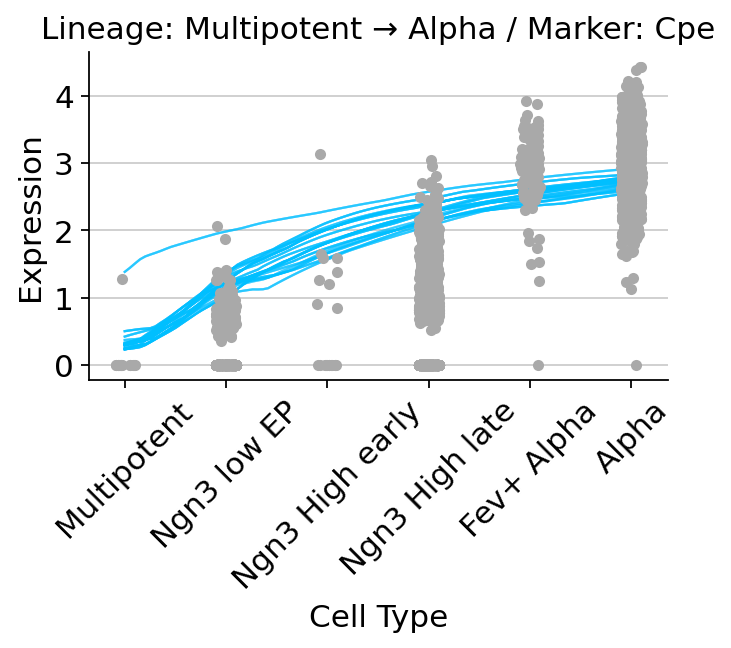

<Figure size 240x240 with 0 Axes>

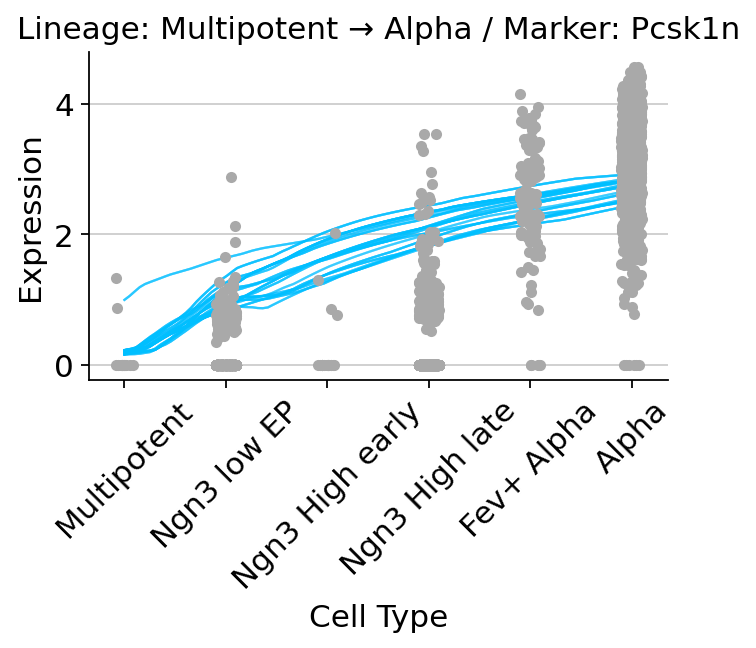

<Figure size 240x240 with 0 Axes>

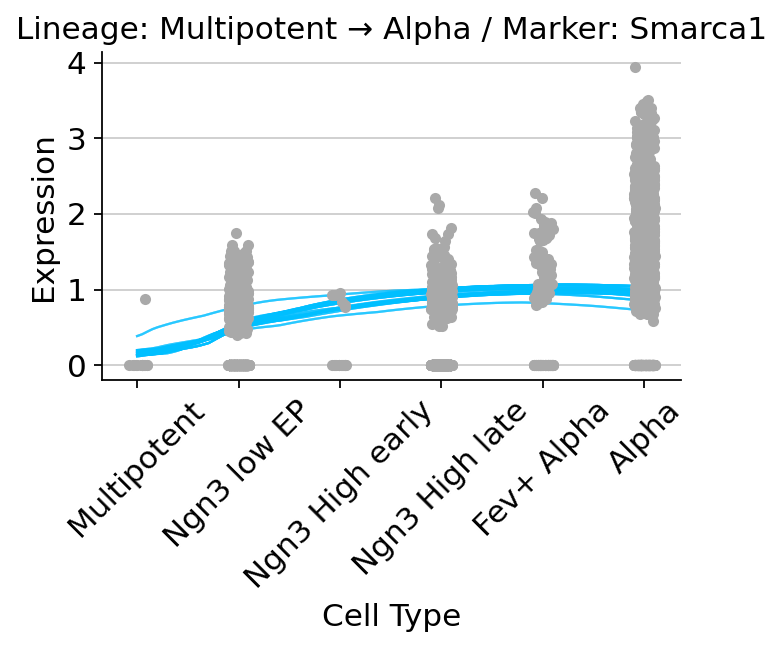

<Figure size 240x240 with 0 Axes>

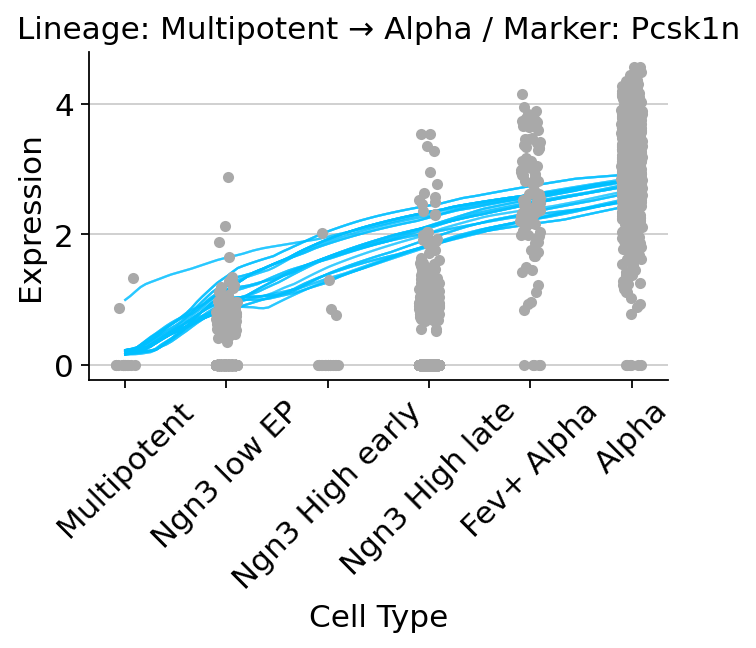

<Figure size 240x240 with 0 Axes>

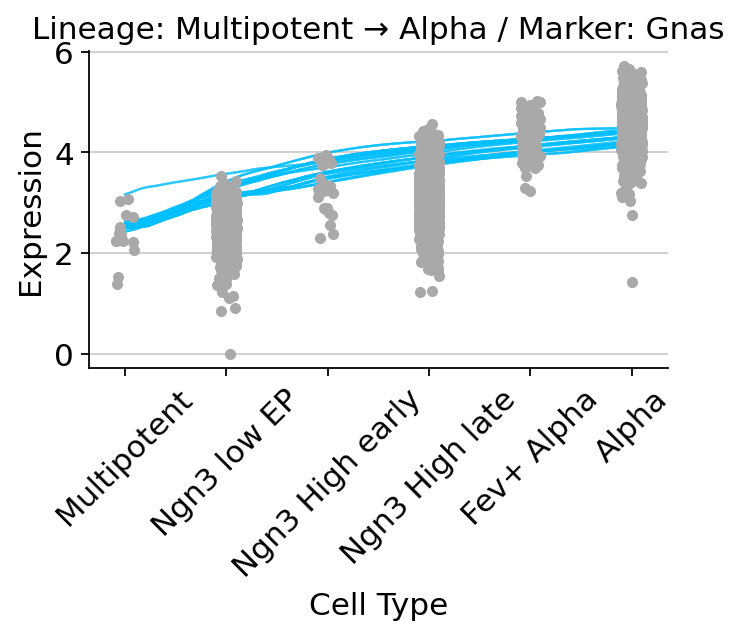

<Figure size 240x240 with 0 Axes>

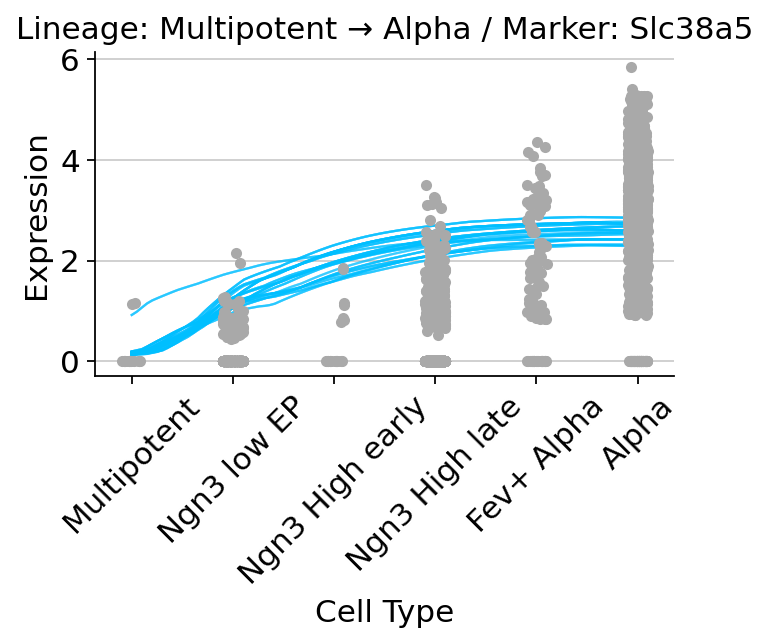

<Figure size 240x240 with 0 Axes>

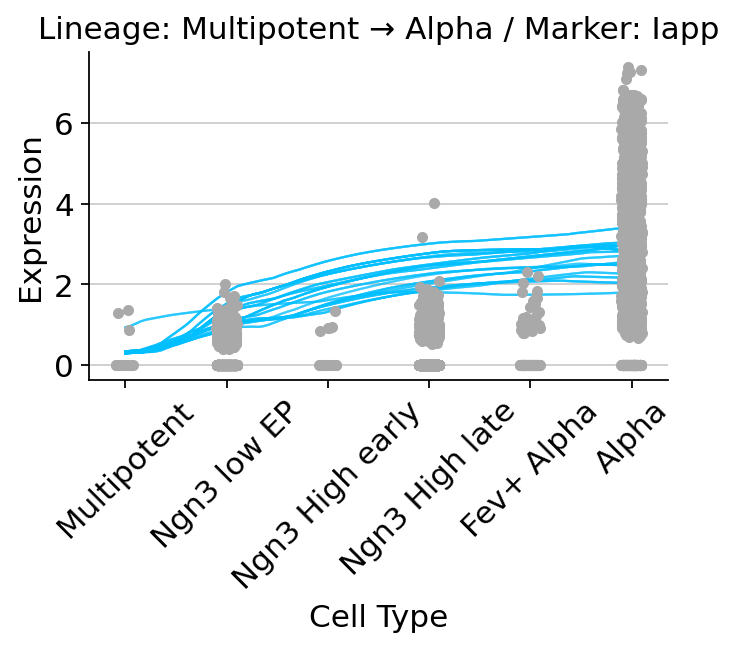

<Figure size 240x240 with 0 Axes>

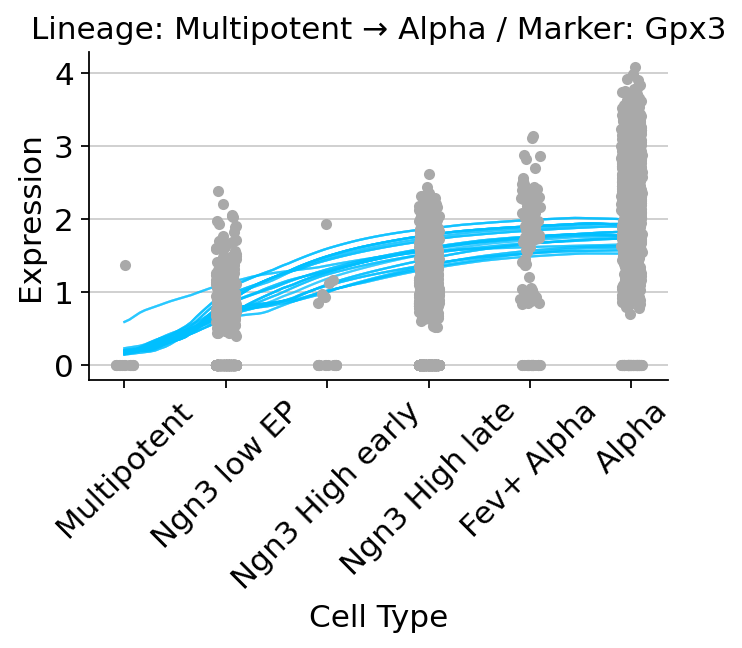

<Figure size 240x240 with 0 Axes>

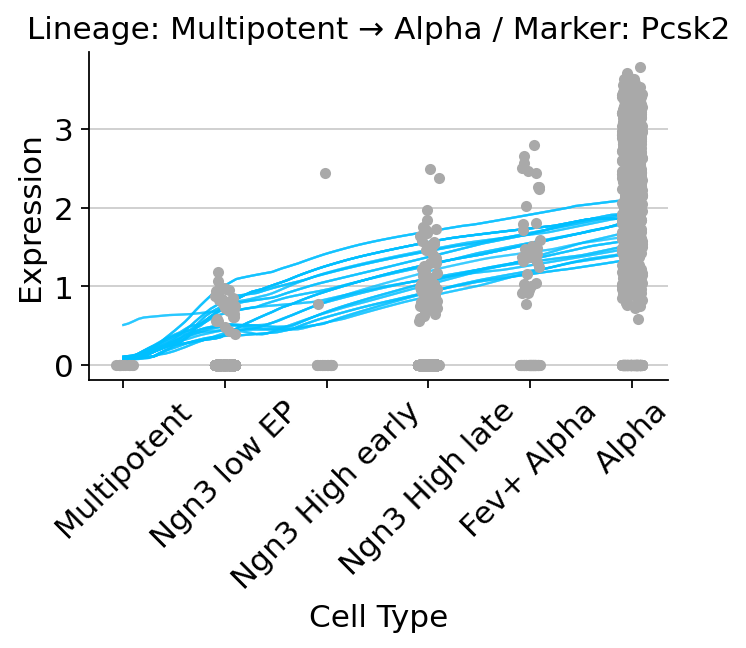

<Figure size 240x240 with 0 Axes>

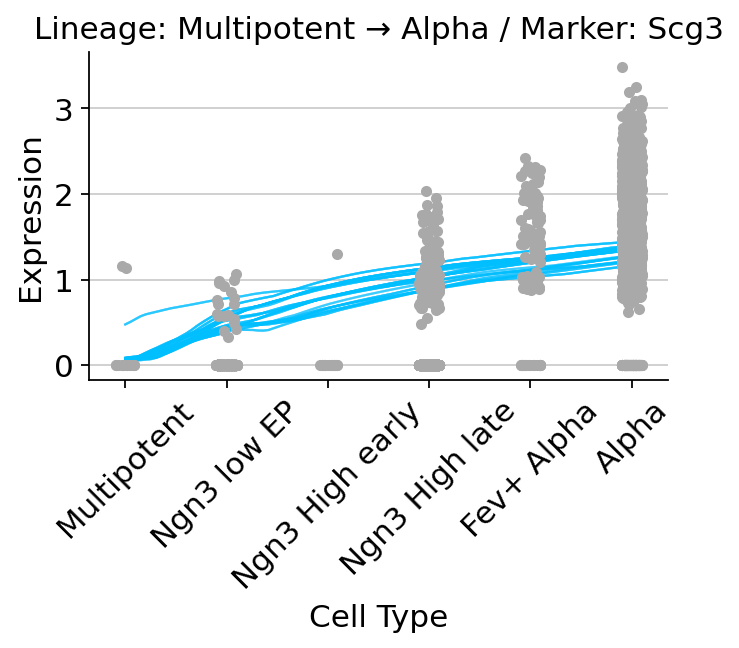

<Figure size 240x240 with 0 Axes>

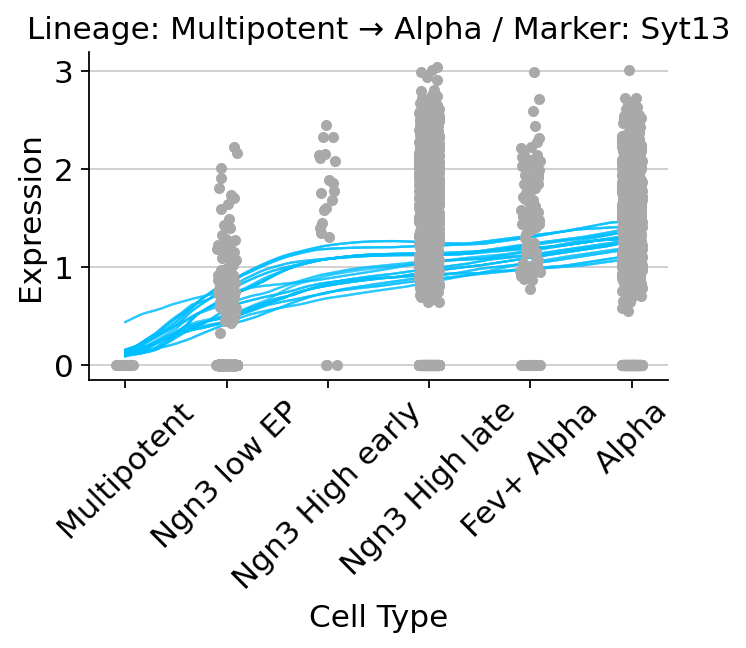

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | odefunc | ODEFunc | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


<Figure size 240x240 with 0 Axes>

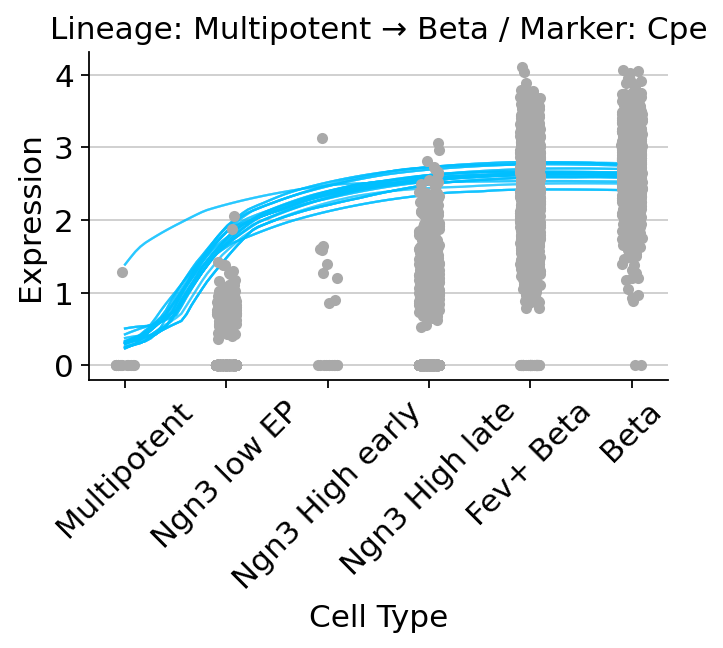

<Figure size 240x240 with 0 Axes>

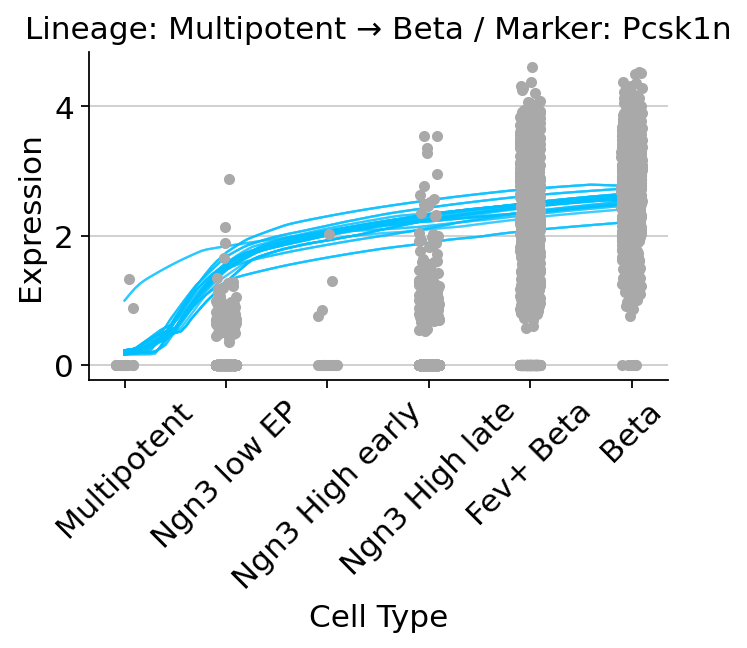

<Figure size 240x240 with 0 Axes>

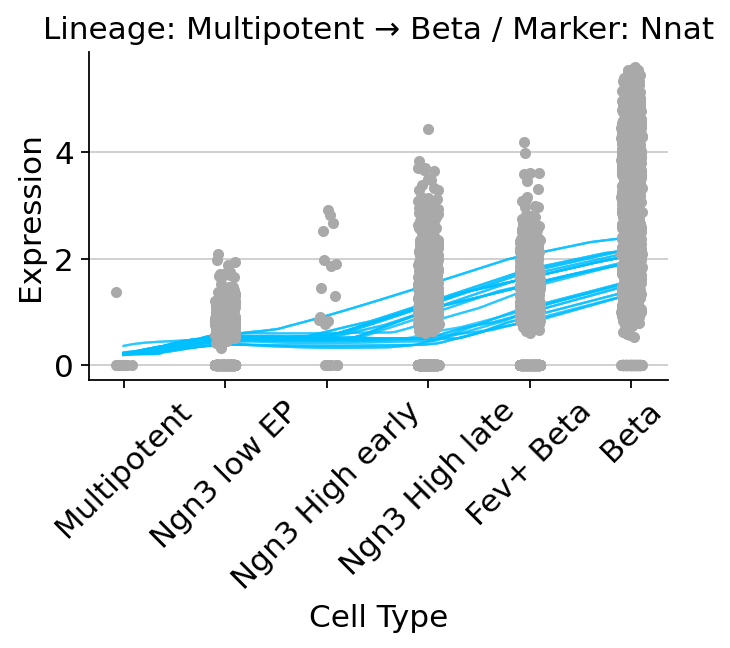

<Figure size 240x240 with 0 Axes>

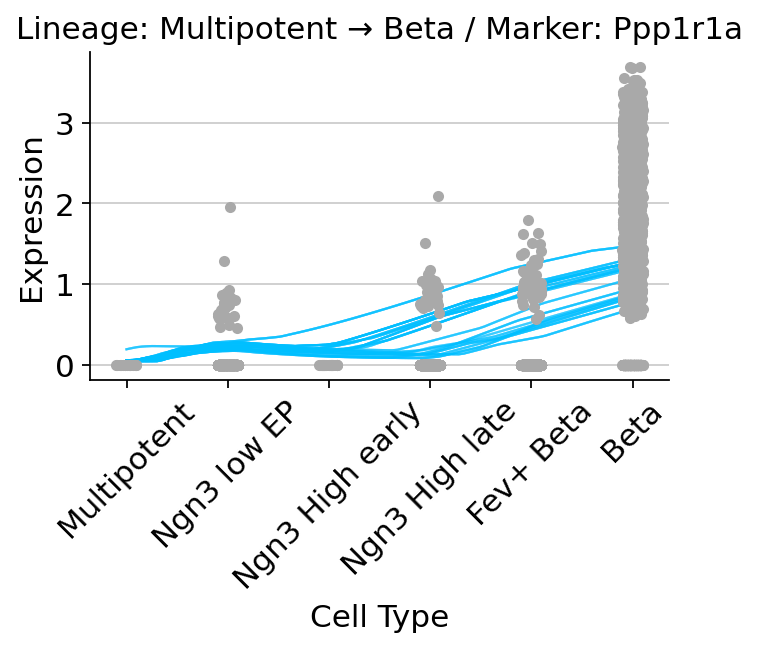

<Figure size 240x240 with 0 Axes>

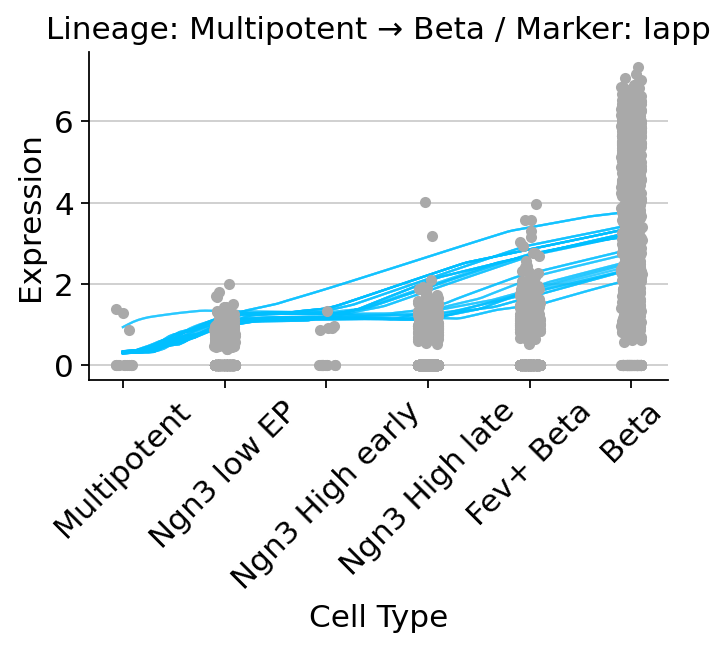

<Figure size 240x240 with 0 Axes>

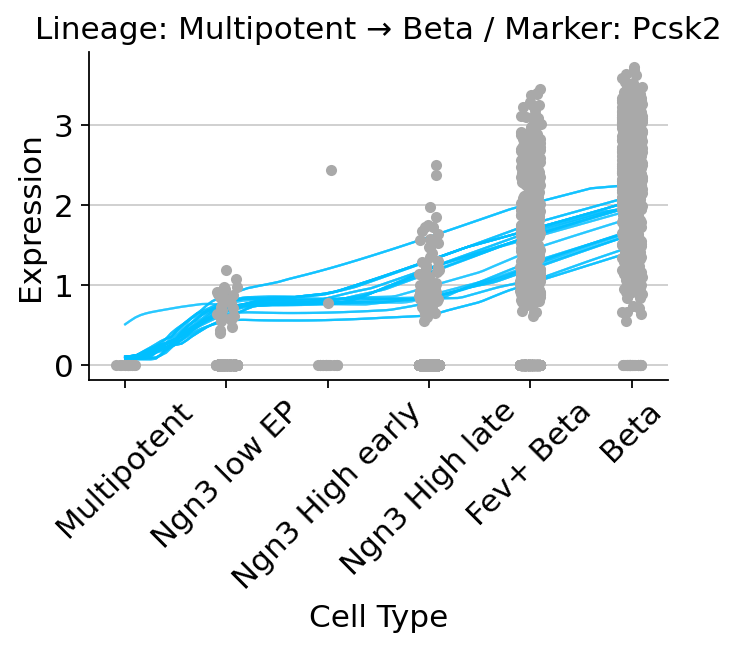

<Figure size 240x240 with 0 Axes>

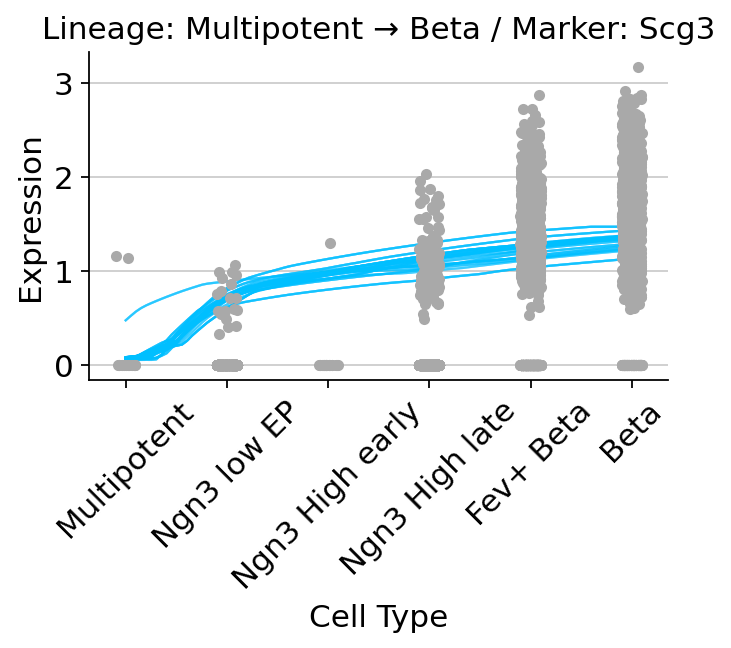

<Figure size 240x240 with 0 Axes>

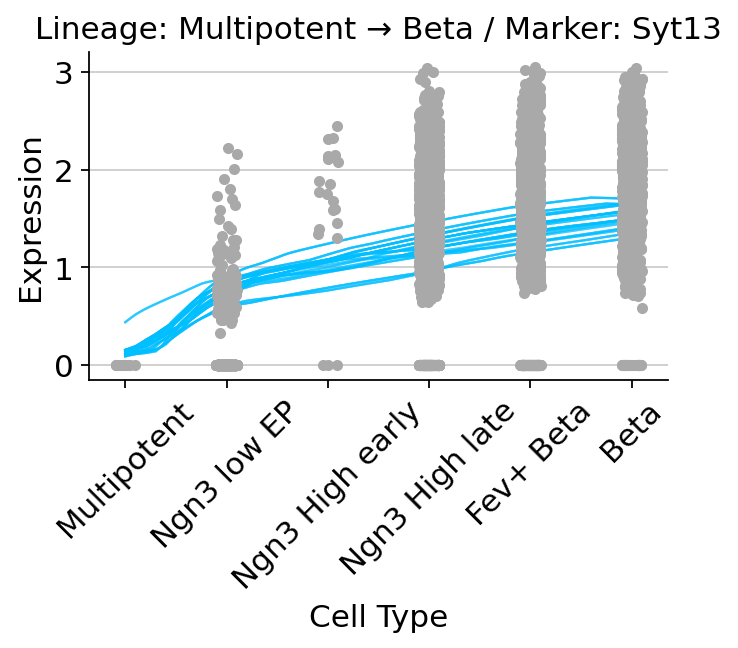

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | odefunc | ODEFunc | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


<Figure size 240x240 with 0 Axes>

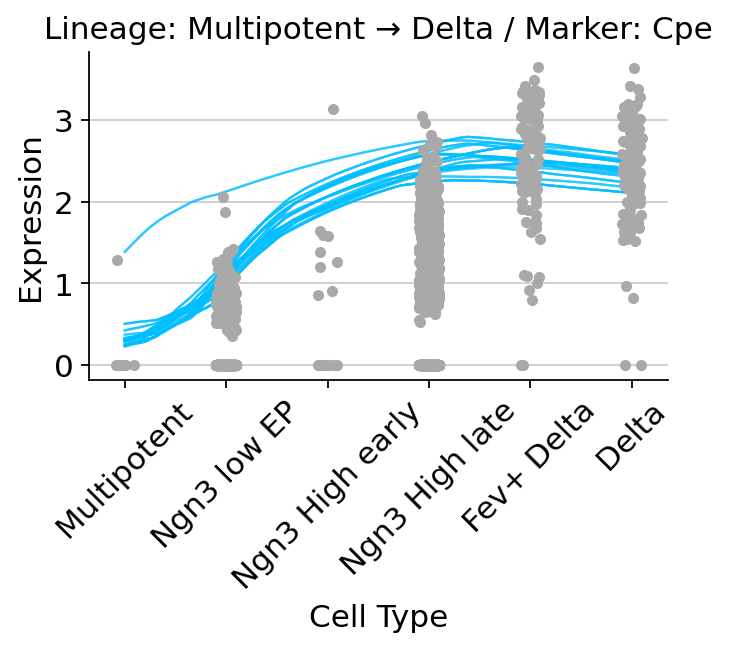

<Figure size 240x240 with 0 Axes>

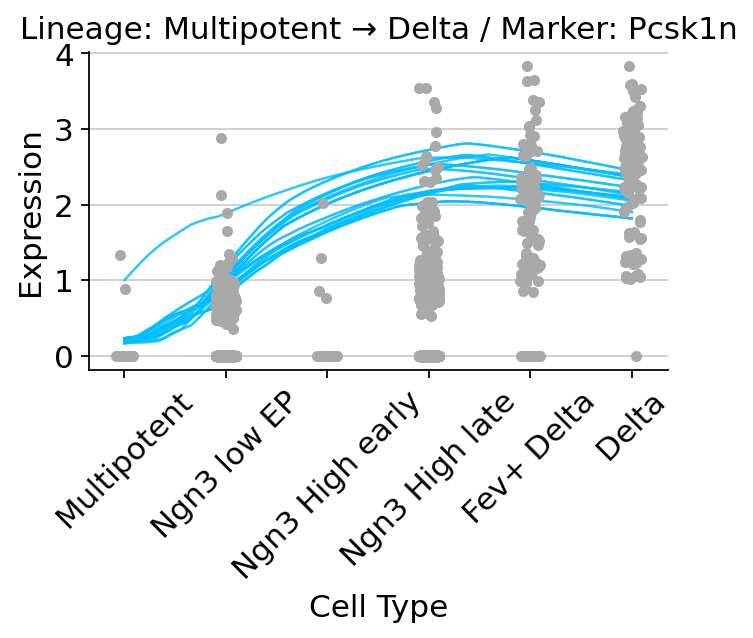

<Figure size 240x240 with 0 Axes>

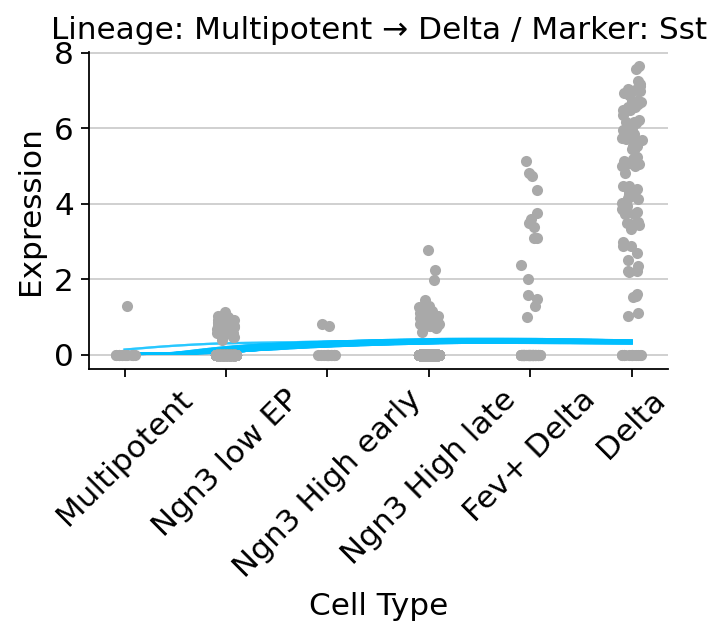

<Figure size 240x240 with 0 Axes>

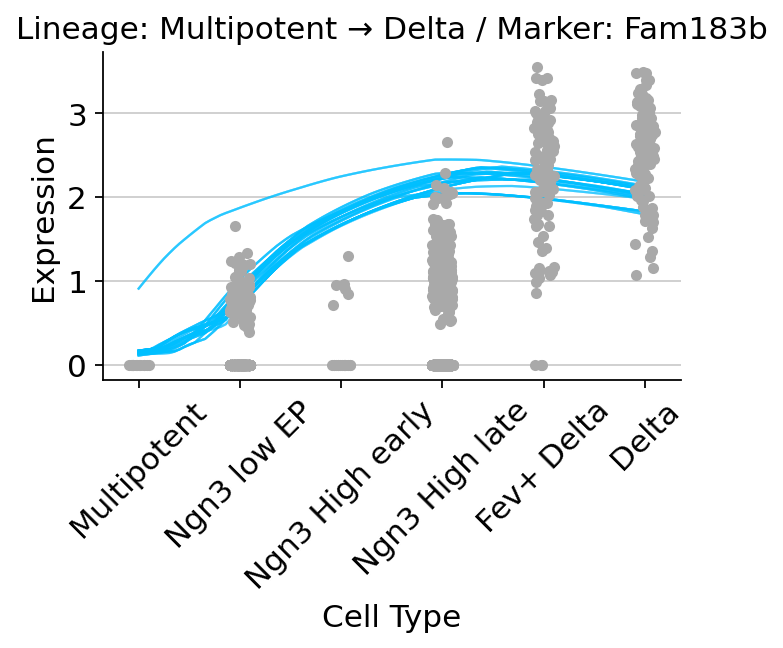

<Figure size 240x240 with 0 Axes>

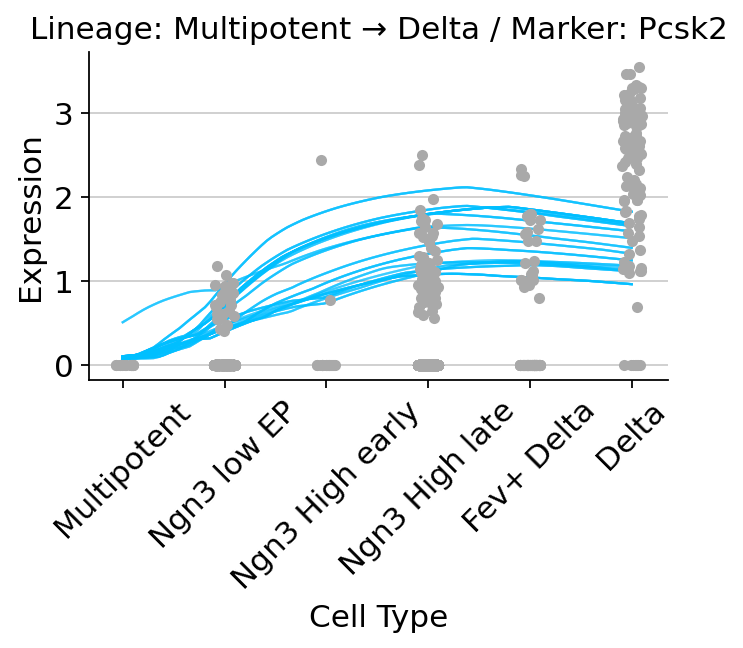

<Figure size 240x240 with 0 Axes>

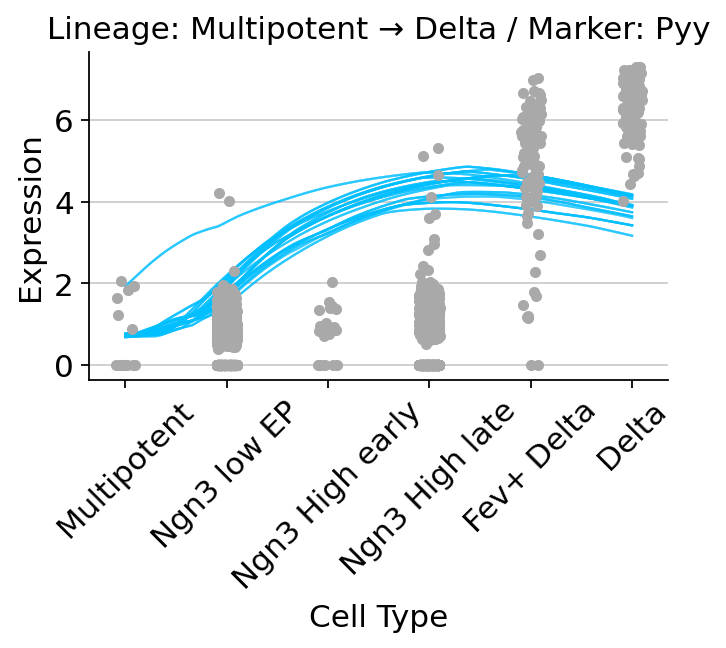

<Figure size 240x240 with 0 Axes>

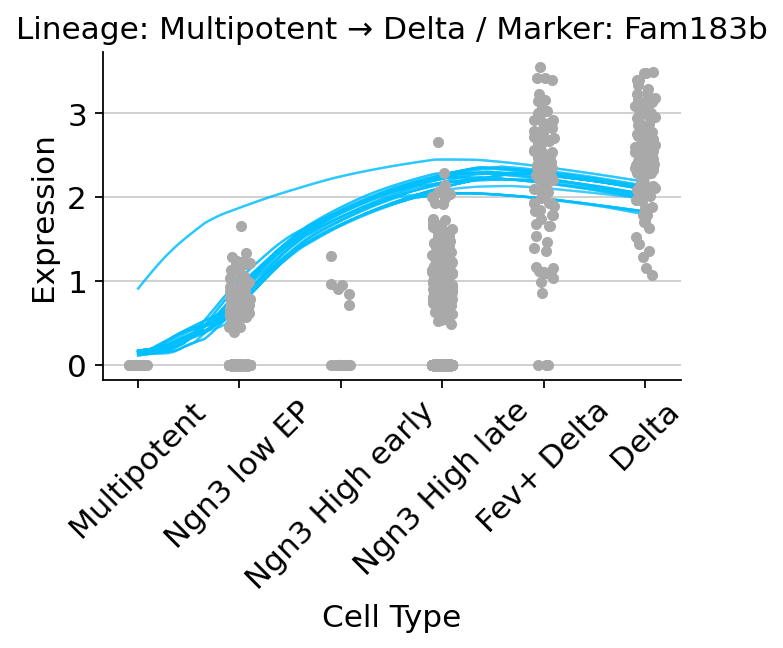

<Figure size 240x240 with 0 Axes>

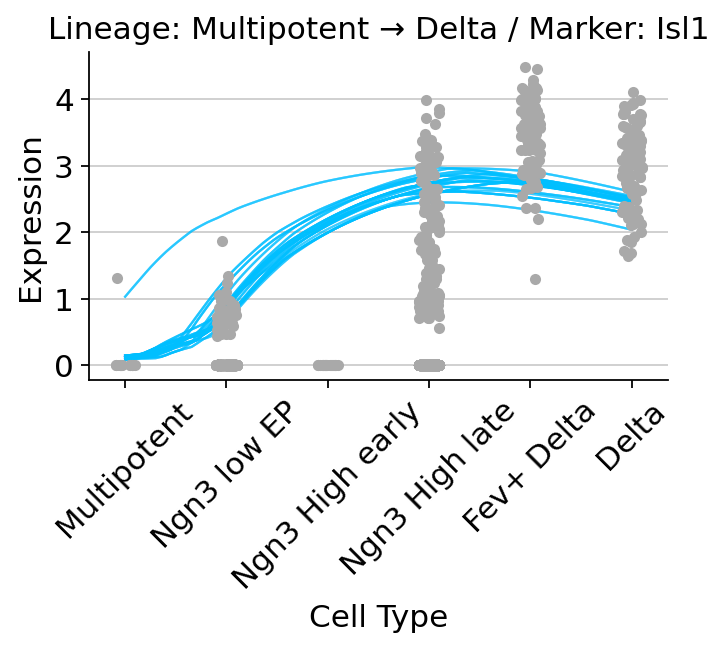

<Figure size 240x240 with 0 Axes>

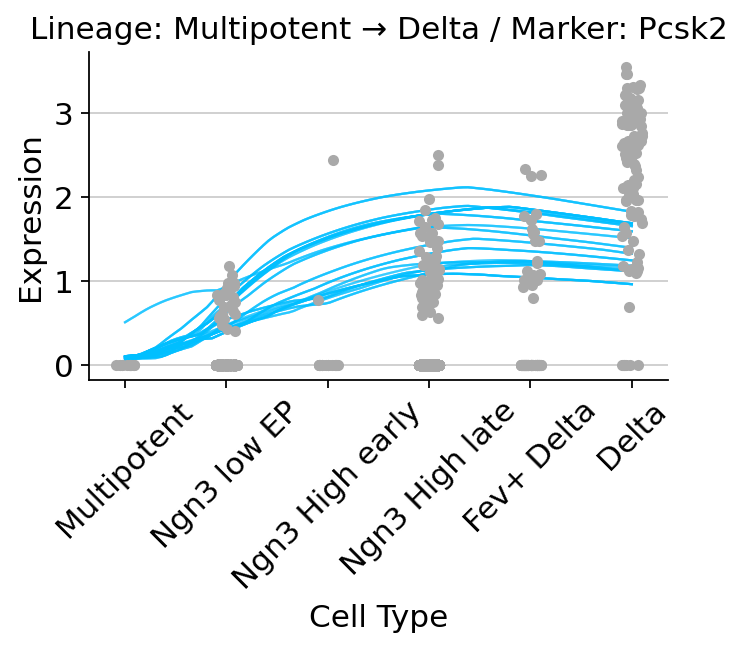

<Figure size 240x240 with 0 Axes>

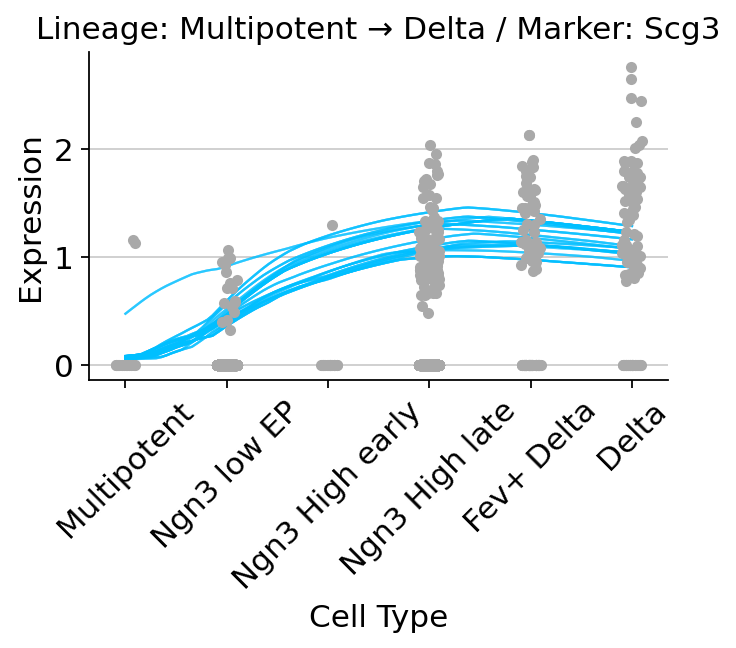

<Figure size 240x240 with 0 Axes>

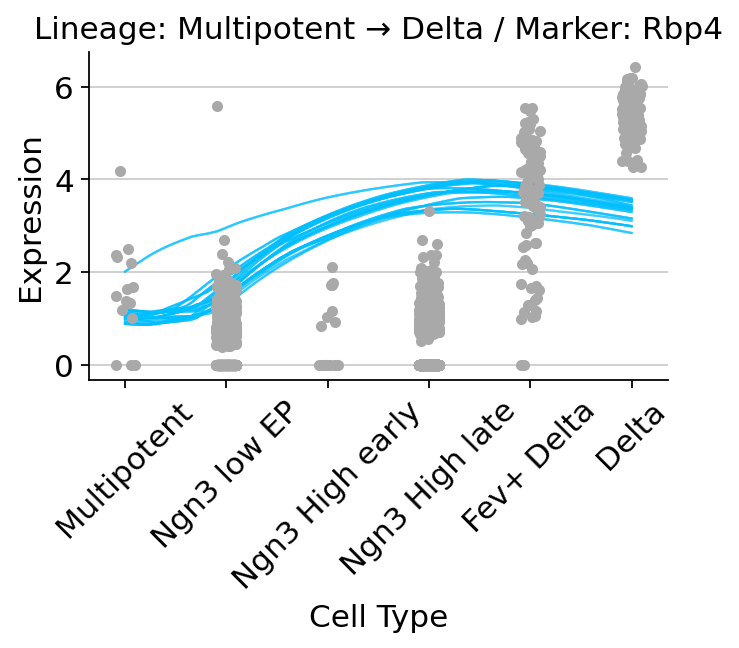

<Figure size 240x240 with 0 Axes>

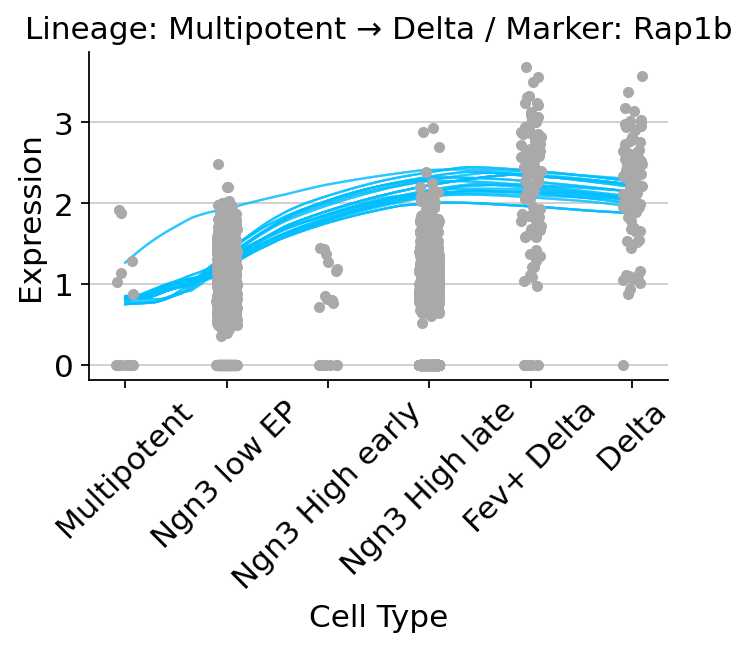

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | odefunc | ODEFunc | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


<Figure size 240x240 with 0 Axes>

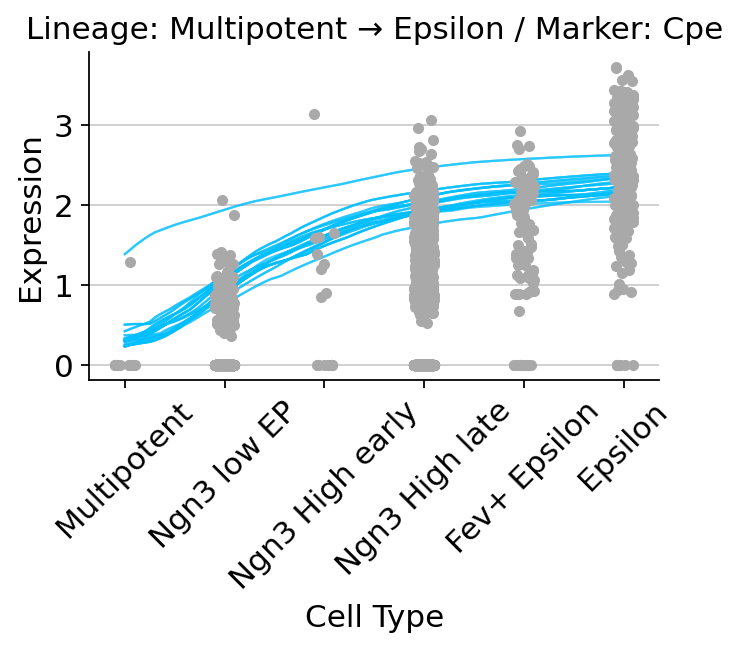

<Figure size 240x240 with 0 Axes>

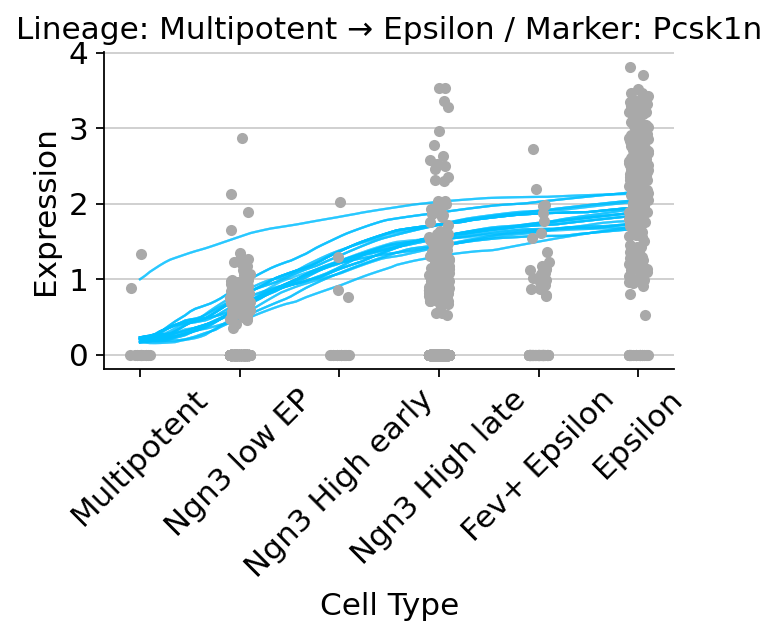

<Figure size 240x240 with 0 Axes>

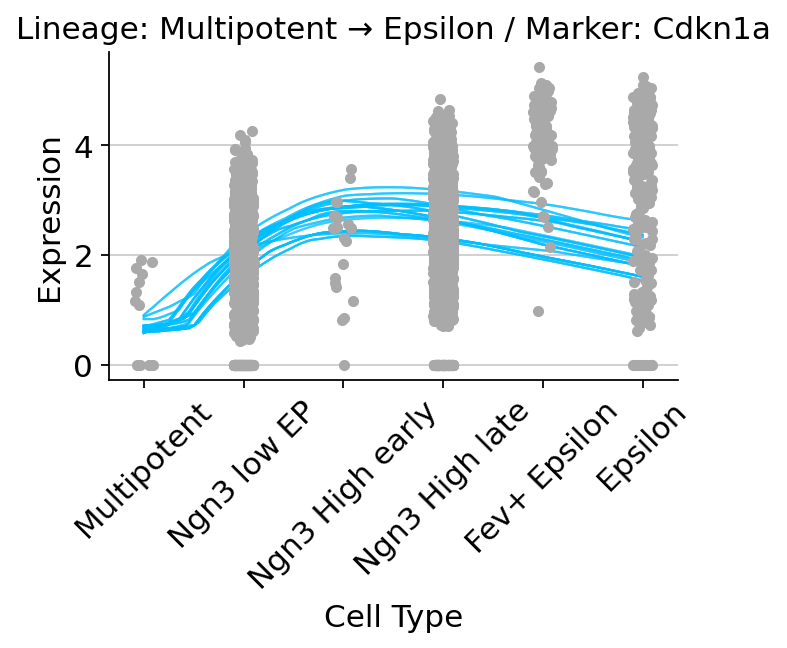

<Figure size 240x240 with 0 Axes>

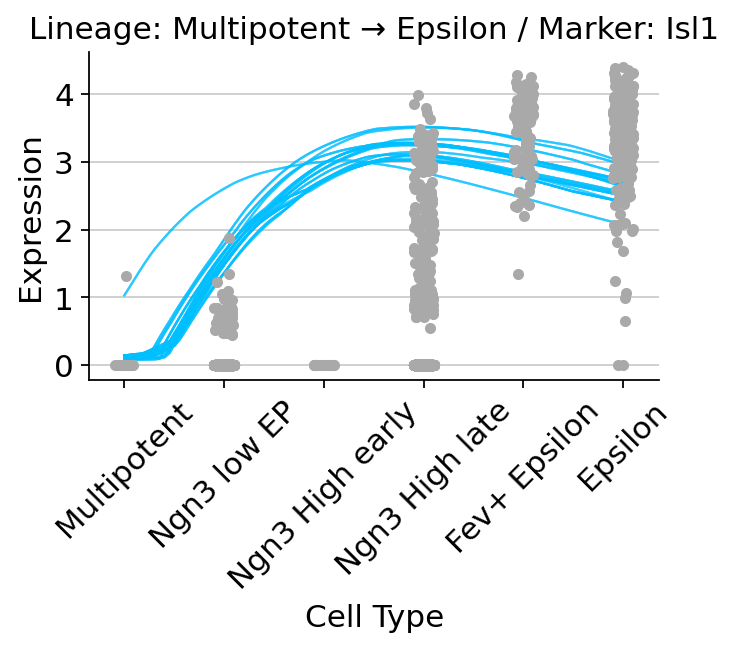

<Figure size 240x240 with 0 Axes>

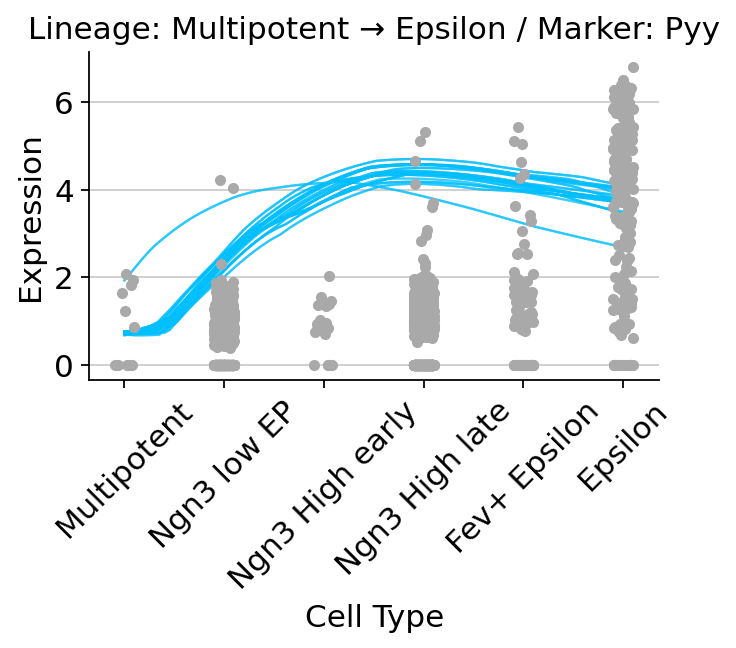

<Figure size 240x240 with 0 Axes>

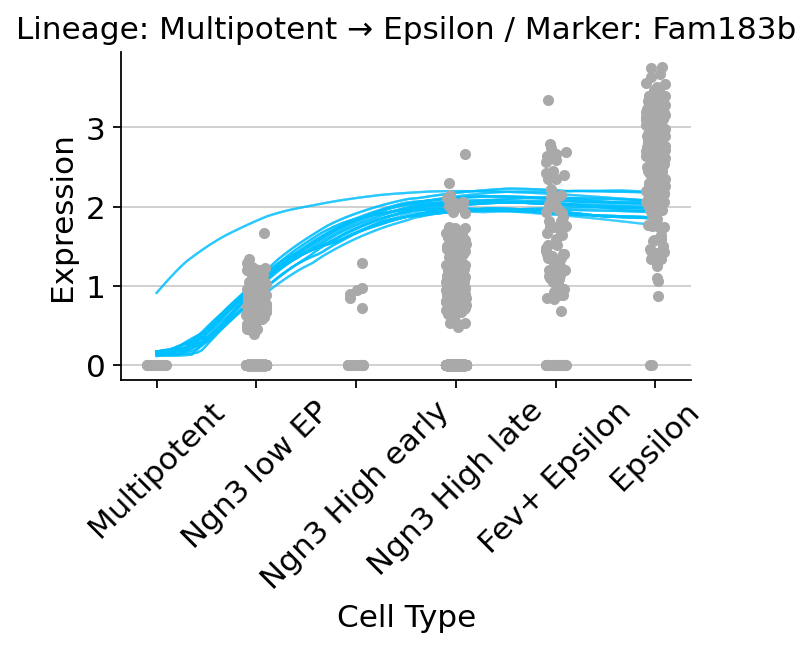

<Figure size 240x240 with 0 Axes>

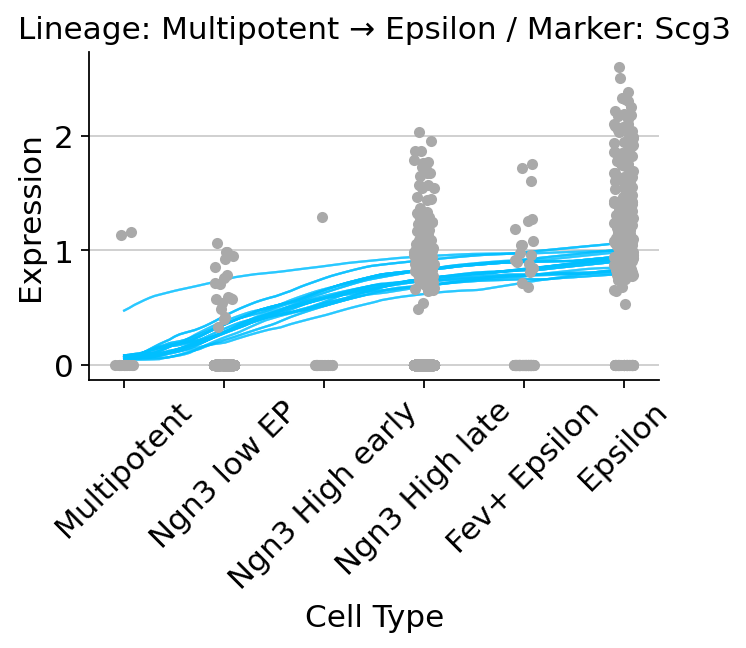

<Figure size 240x240 with 0 Axes>

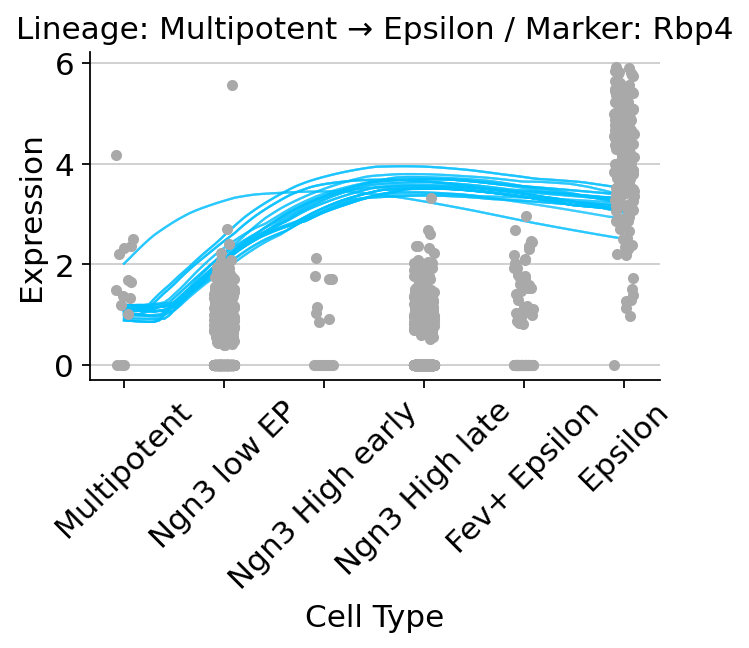

<Figure size 240x240 with 0 Axes>

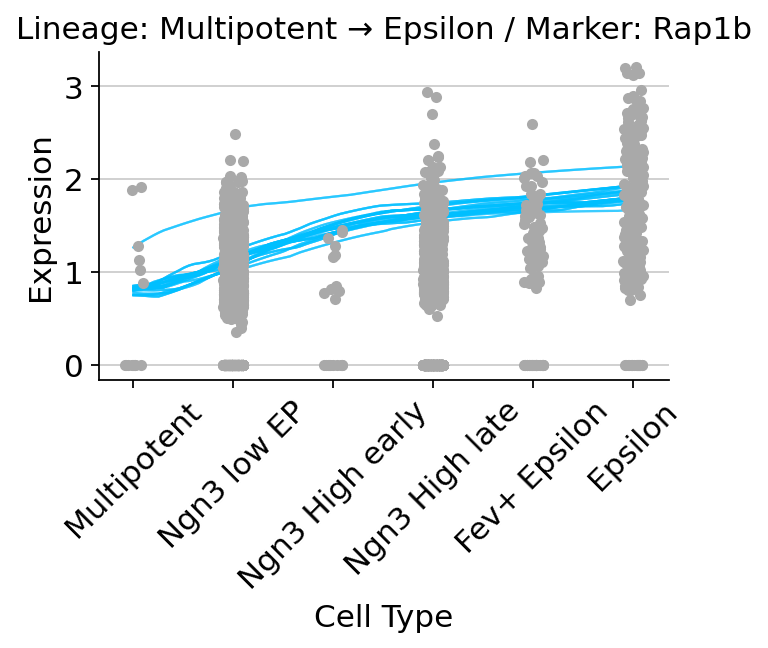

In [9]:
for celltype in pancreatic_lineage_markers:
    z_traj_ct = interpolation_pair_ct(adata, 
                                      "Multipotent", 
                                      celltype, 
                                      100,
                                      100,
                                      model)

    # torch.save(z_traj_ct, f"/lustre/groups/ml01/workspace/alessandro.palma/scCFM/baselines/gaga/{celltype}.pt")
    
    ct_order = pancreatic_lineage_markers[celltype]["lineage"]
    for gene in pancreatic_lineage_markers[celltype]["markers"]:
        plot_gene_expression_by_celltype(adata, 
                                         ct_order, 
                                         gene, 
                                         z_traj_ct.numpy(), 
                                         plot_average=False)

In [ ]:
for celltype in pancreatic_lineage_markers:
    z_traj_ct = interpolation_pair_ct(adata, 
                                      "Multipotent", 
                                      celltype, 
                                      100,
                                      100,
                                      model)

    # torch.save(z_traj_ct, f"/lustre/groups/ml01/workspace/alessandro.palma/scCFM/baselines/gaga/predictions/{celltype}.pt")
    
    ct_order = pancreatic_lineage_markers[celltype]["lineage"]
    for gene in pancreatic_lineage_markers[celltype]["markers"]:
        plot_gene_expression_by_celltype(adata, 
                                         ct_order, 
                                         gene, 
                                         z_traj_ct.numpy(), 
                                         plot_average=False)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | odefunc | ODEFunc | 1.4 K 
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]